# Notebook Phân tích Phân loại (Classification Analysis)

Notebook này thực hiện bài toán **Phân loại (Classification)** sử dụng ba phương pháp theo yêu cầu:
1.  **K-Nearest Neighbors (KNN)** (Thuật toán Phân loại chính thức).
2.  **K-Means Clustering** (Được sử dụng như một Pseudo-Classifier).
3.  **Hierarchical Clustering (HC)** (Được sử dụng như một Pseudo-Classifier).

Các bước chính:
1.  Tạo dữ liệu mẫu 2D có nhãn (supervised data) **với độ nhiễu cao** và chia thành tập Train/Test.
2.  Tìm tham số K tối ưu cho KNN (dựa trên độ chính xác).
3.  **Visualize kết quả phân loại** của KNN.
4.  Tìm tham số K tối ưu cho K-Means (dựa trên Elbow Method).
5.  **Visualize kết quả phân cụm** của K-Means và HC.
6.  Đánh giá và so sánh hiệu suất của cả ba mô hình.

In [38]:
# ==================================
# 1. KHỞI TẠO VÀ IMPORT THƯ VIỆN
# ==================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dữ liệu và Tiền xử lý
from sklearn.datasets import make_classification 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Mô hình Phân loại/Phân cụm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Đánh giá
from sklearn.metrics import accuracy_score, confusion_matrix

# Cài đặt chung cho biểu đồ
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 100

## 1. Tạo dữ liệu mẫu và Tiền xử lý

Tạo dữ liệu 2D có nhãn (4 lớp) với độ nhiễu cao để mô hình không bị quá khớp. Chúng ta sử dụng `make_classification`.

Thông số tạo dữ liệu mới:
* `n_informative=2`: Chỉ 2 feature có ý nghĩa (phù hợp với việc visualize 2D).
* `class_sep=0.5`: Giảm khoảng cách giữa các lớp, khiến chúng chồng lấn nhiều hơn.
* `flip_y=0.1`: 10% nhãn bị gán sai ngẫu nhiên (nhiễu nhãn).


In [52]:
# Tạo dữ liệu phân loại với độ chồng lấn cao và nhiễu nhãn
X, y_true = make_classification(
    n_samples=400,
    n_features=2,            # 2 features để dễ visualize
    n_informative=2,
    n_redundant=0,
    n_classes=4,             # 4 lớp
    n_clusters_per_class=1,
    class_sep=1.2,           # Giảm khoảng cách giữa các lớp (chồng lấn)
    flip_y=0.1,              # 10% nhãn bị gán sai (nhiễu nhãn)
    random_state=42
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Hình dạng của dữ liệu (X_scaled): {X_scaled.shape}")
print(f"Hình dạng của nhãn (y_true): {y_true.shape}")

Hình dạng của dữ liệu (X_scaled): (400, 2)
Hình dạng của nhãn (y_true): (400,)


### Chia tập Train và Test

Chúng ta chia dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%).

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_true, test_size=0.2, random_state=42, stratify=y_true
)

print(f"Tập huấn luyện: {X_train.shape[0]} mẫu")
print(f"Tập kiểm tra: {X_test.shape[0]} mẫu")

Tập huấn luyện: 320 mẫu
Tập kiểm tra: 80 mẫu


### Visualize dữ liệu gốc

Trực quan hóa dữ liệu đã được gán nhãn thật (True Labels).

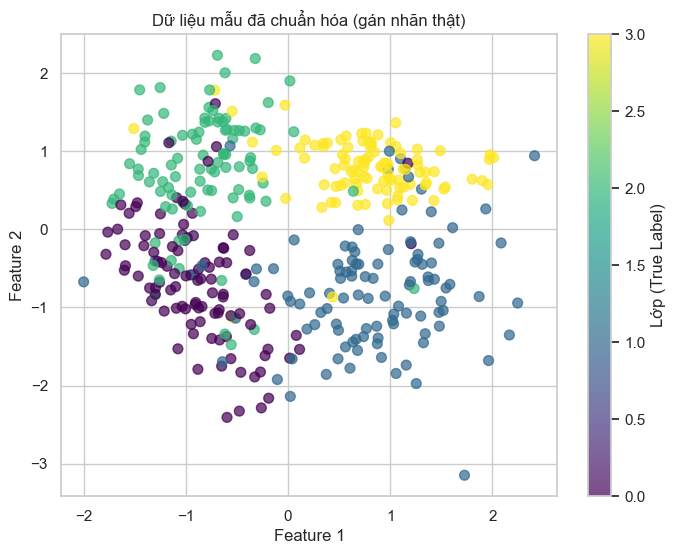

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_true, s=50, alpha=0.7, cmap='viridis')
plt.title('Dữ liệu mẫu đã chuẩn hóa (gán nhãn thật)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Lớp (True Label)')
plt.grid(True)
plt.show()

## 2. K-Nearest Neighbors (KNN) Classification

### Cách tìm K tối ưu cho KNN
Tìm giá trị $K$ (số lượng hàng xóm) tối ưu bằng cách đánh giá **Độ chính xác (Accuracy)** trên tập kiểm tra với các giá trị $K$ khác nhau.

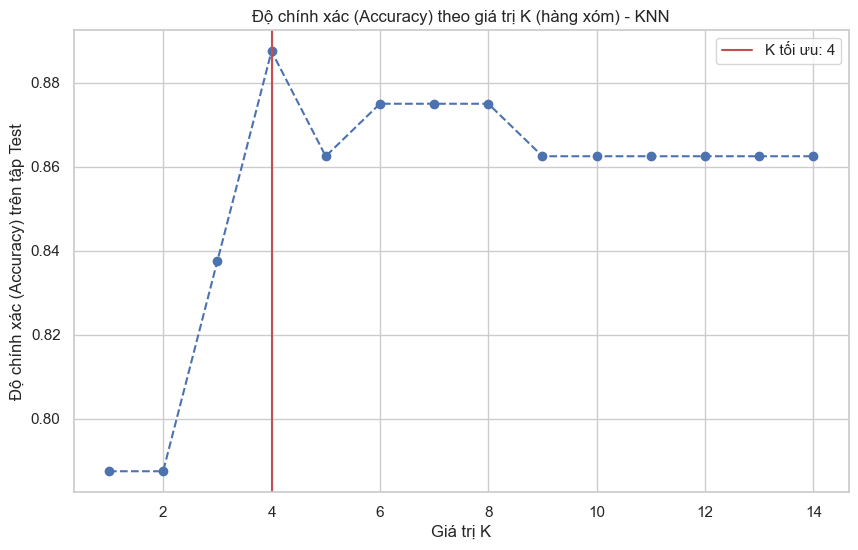

K tối ưu cho KNN là: 4


In [55]:
# 2.1. Tìm K tối ưu cho KNN
k_range = range(1, 15)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred_k))

# Tìm K có điểm số cao nhất
optimal_k_knn = k_range[np.argmax(scores)]

plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='--')
plt.title('Độ chính xác (Accuracy) theo giá trị K (hàng xóm) - KNN')
plt.xlabel('Giá trị K')
plt.ylabel('Độ chính xác (Accuracy) trên tập Test')
plt.axvline(x=optimal_k_knn, color='r', linestyle='-', label=f'K tối ưu: {optimal_k_knn}')
plt.legend()
plt.grid(True)
plt.show()
print(f"K tối ưu cho KNN là: {optimal_k_knn}")

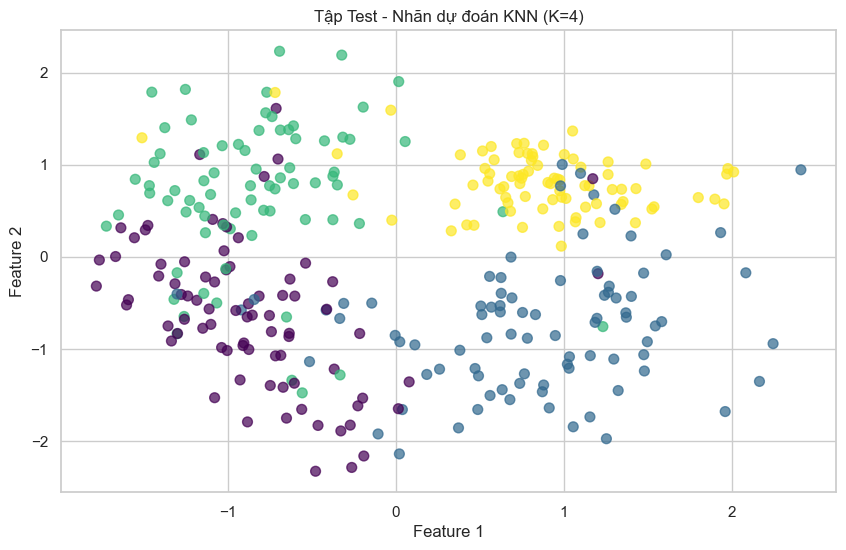

In [56]:
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)
y_pred_k = knn.predict(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred_k, s=50, alpha=0.7, cmap='viridis')
plt.title(f'Tập Test - Nhãn dự đoán KNN (K={optimal_k_knn})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Accuracy (KNN): 0.8875


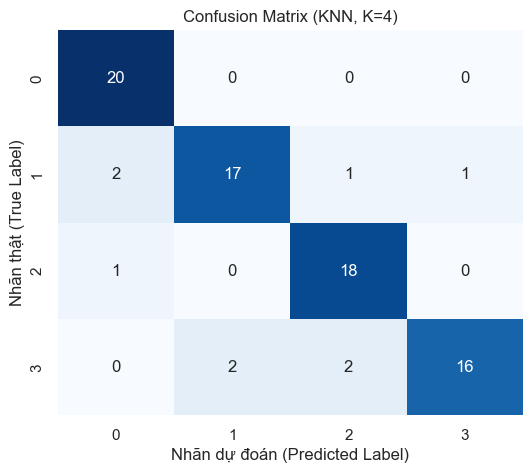

In [57]:
# 2.2. Huấn luyện, Dự đoán và Đánh giá KNN với K tối ưu
knn_final = KNeighborsClassifier(n_neighbors=optimal_k_knn, weights='distance')
knn_final.fit(X_train, y_train)
y_pred_knn = knn_final.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (KNN): {accuracy_knn:.4f}")

# Ma trận nhầm lẫn (Confusion Matrix)
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (KNN, K={optimal_k_knn})')
plt.ylabel('Nhãn thật (True Label)')
plt.xlabel('Nhãn dự đoán (Predicted Label)')
plt.show()

## 3. K-Means (Pseudo-Classifier)

### Cách tìm K tối ưu cho K-Means
Dùng phương pháp **khuỷu tay (Elbow Method)** dựa trên WCSS (Within-Cluster Sum of Squares) để tìm số cụm $K$ tốt nhất.

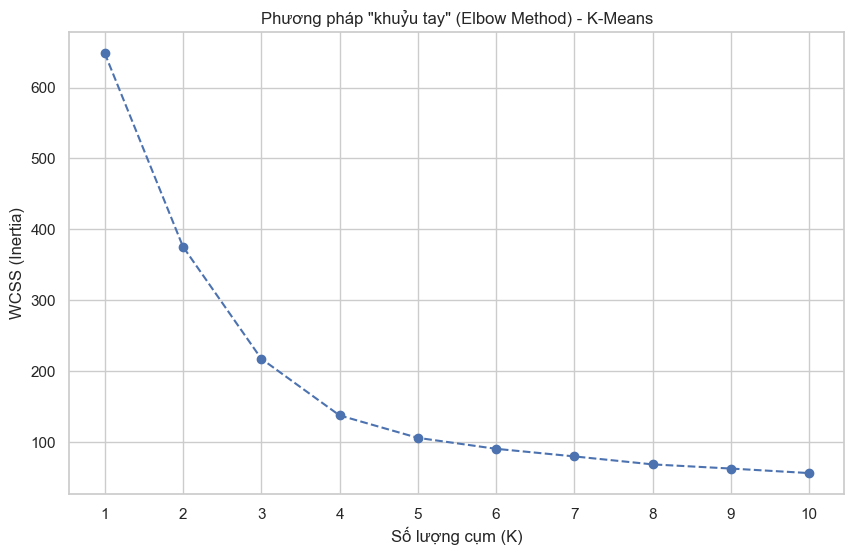

K tối ưu cho K-Means (dựa trên Elbow) là: 4


In [58]:
# 3.1. Tìm K tối ưu bằng Elbow Method
wcss = [] # Within-Cluster Sum of Squares
K_range = range(1, 11)

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_test.fit(X_train)
    wcss.append(kmeans_test.inertia_) # inertia_ là WCSS

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Phương pháp "khuỷu tay" (Elbow Method) - K-Means')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K_range)
plt.grid(True)
plt.show()
optimal_k_kmeans = 4 # Chọn K=4 vì dữ liệu gốc có 4 lớp
print(f"K tối ưu cho K-Means (dựa trên Elbow) là: {optimal_k_kmeans}")

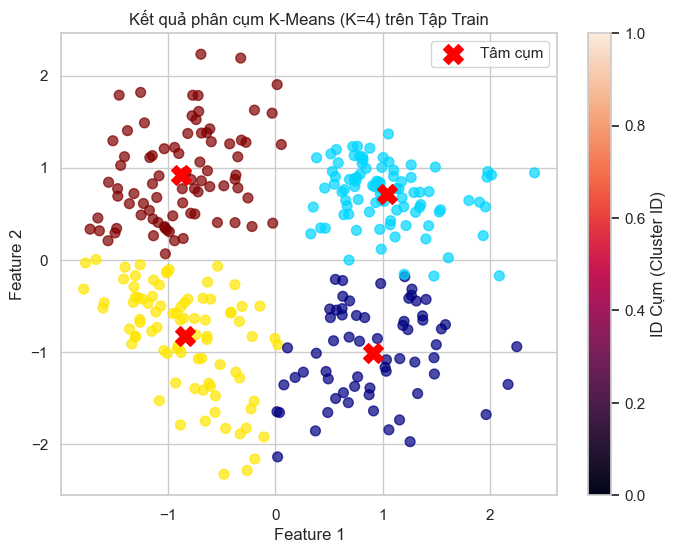

In [59]:
# 3.2. Huấn luyện K-Means và Visualize kết quả phân cụm (trên tập Train)
kmeans = KMeans(n_clusters=optimal_k_kmeans, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X_train)
train_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, s=50, alpha=0.7, cmap='jet')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=200, color='red', label='Tâm cụm')
plt.title(f'Kết quả phân cụm K-Means (K={optimal_k_kmeans}) trên Tập Train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='ID Cụm (Cluster ID)')
plt.legend()
plt.grid(True)
plt.show()

Accuracy (K-Means Pseudo-Classifier): 0.8500


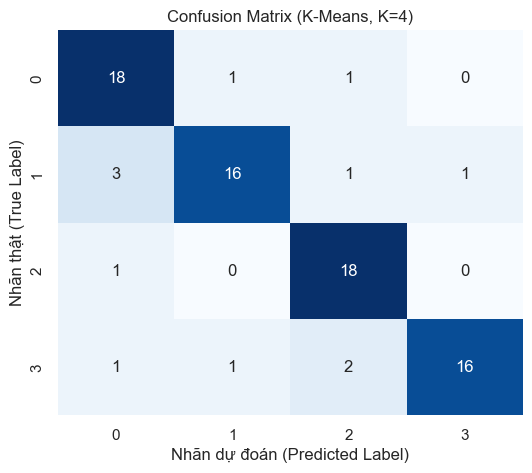

In [60]:
from collections import Counter

def map_clusters_to_labels(cluster_labels, true_labels):
    """Tạo ánh xạ từ ID cụm sang ID lớp (nhãn thật) bằng Bỏ phiếu Đa số."""
    mapping = {}
    for cluster_id in np.unique(cluster_labels):
        # Lọc nhãn thật của các điểm thuộc cụm này
        mask = (cluster_labels == cluster_id)
        true_labels_in_cluster = true_labels[mask]
        
        # Tìm nhãn thật phổ biến nhất (đa số)
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        mapping[cluster_id] = most_common_label
    return mapping

# 3.3. Ánh xạ và Đánh giá K-Means Pseudo-Classifier
# Dự đoán nhãn cụm trên tập Test
test_cluster_labels = kmeans.predict(X_test)

# Ánh xạ cụm trên tập Train
cluster_to_label_map = map_clusters_to_labels(train_cluster_labels, y_train)

# Áp dụng ánh xạ để dự đoán nhãn lớp trên tập Test
y_pred_kmeans = np.array([cluster_to_label_map[cluster_id] for cluster_id in test_cluster_labels])

# Đánh giá
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
print(f"Accuracy (K-Means Pseudo-Classifier): {accuracy_kmeans:.4f}")

# Ma trận nhầm lẫn
cm_kmeans = confusion_matrix(y_test, y_pred_kmeans)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (K-Means, K={optimal_k_kmeans})')
plt.ylabel('Nhãn thật (True Label)')
plt.xlabel('Nhãn dự đoán (Predicted Label)')
plt.show()

## 4. Hierarchical Clustering (Pseudo-Classifier)

### Cách tìm K tối ưu cho HC
Dùng biểu đồ **Dendrogram** để tìm điểm cắt tối ưu (tương đương với số lượng cụm $K$ tốt nhất).

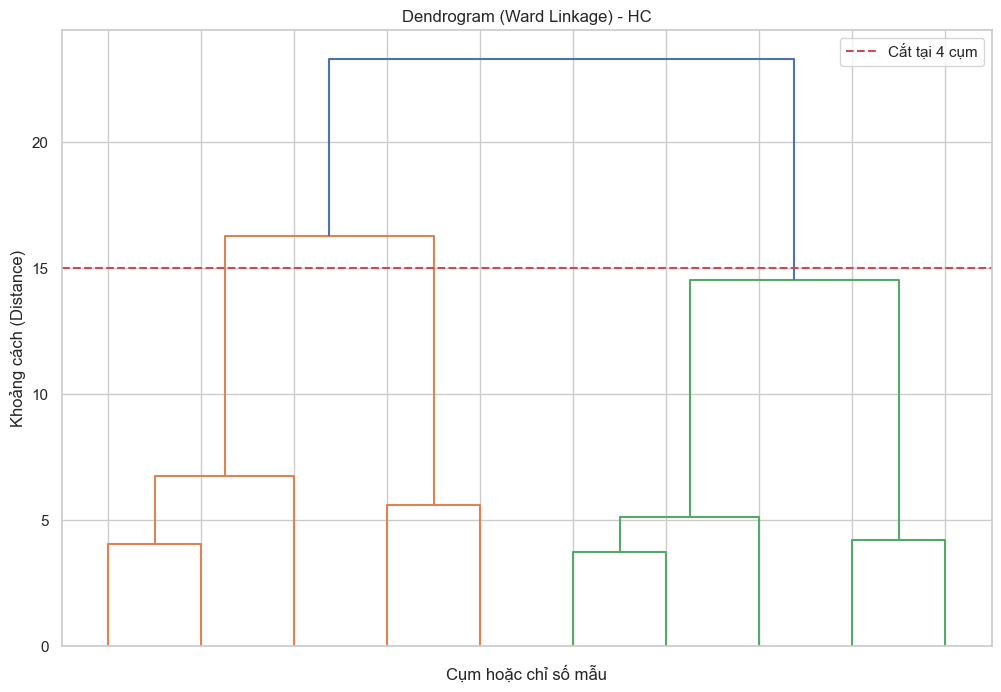

K tối ưu cho Hierarchical Clustering (dựa trên Dendrogram) là: 4


In [61]:
# 4.1. Vẽ Dendrogram để chọn số lượng cụm K
linked = linkage(X_train, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=False,
            truncate_mode='lastp',
            p=10) # Chỉ hiển thị 10 node cuối cùng
plt.title('Dendrogram (Ward Linkage) - HC')
plt.xlabel('Cụm hoặc chỉ số mẫu')
plt.ylabel('Khoảng cách (Distance)')
# Cắt ngang qua 4 đường dọc để có 4 cụm
plt.axhline(y=15, color='r', linestyle='--', label='Cắt tại 4 cụm')
plt.legend()
plt.show()
optimal_k_hc = 4 # Dựa trên đồ thị
print(f"K tối ưu cho Hierarchical Clustering (dựa trên Dendrogram) là: {optimal_k_hc}")

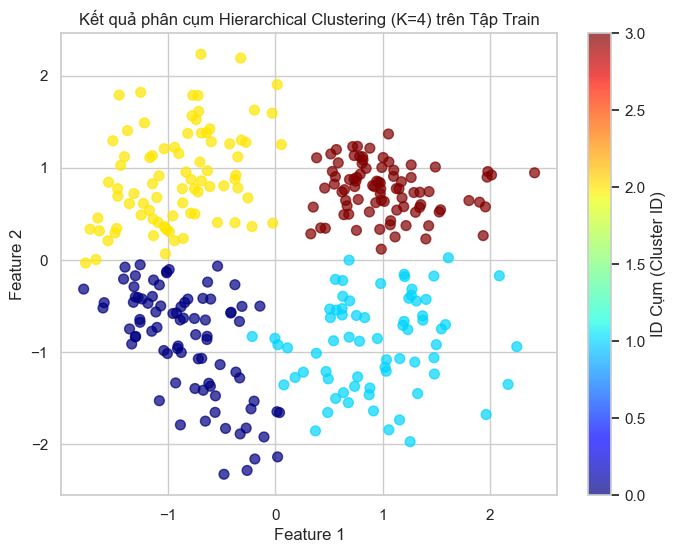

In [62]:
# 4.2. Huấn luyện HC và Visualize kết quả phân cụm (trên tập Train)
# Huấn luyện trên tập Train
hc = AgglomerativeClustering(n_clusters=optimal_k_hc, linkage='ward')
hc_train_labels = hc.fit_predict(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=hc_train_labels, s=50, alpha=0.7, cmap='jet')
plt.title(f'Kết quả phân cụm Hierarchical Clustering (K={optimal_k_hc}) trên Tập Train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='ID Cụm (Cluster ID)')
plt.grid(True)
plt.show()

Accuracy (HC Pseudo-Classifier): 0.8125


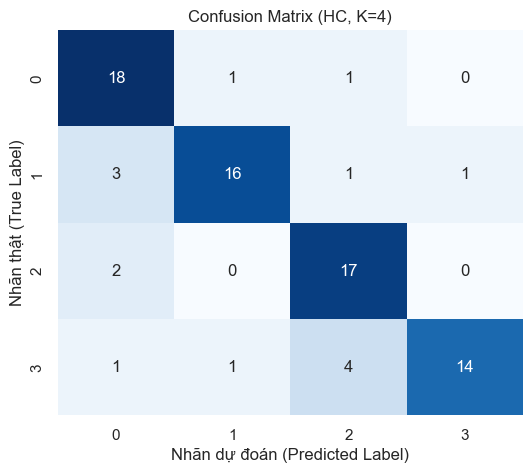

In [63]:
# 4.3. Ánh xạ và Đánh giá HC Pseudo-Classifier

# Sử dụng KNN (K=1) để gán nhãn cụm HC cho tập Test
knn_hc = KNeighborsClassifier(n_neighbors=1)
knn_hc.fit(X_train, hc_train_labels)
test_cluster_labels = knn_hc.predict(X_test)

# Ánh xạ cụm trên tập Train
cluster_to_label_map = map_clusters_to_labels(hc_train_labels, y_train)

# Áp dụng ánh xạ để dự đoán nhãn lớp trên tập Test
y_pred_hc = np.array([cluster_to_label_map[cluster_id] for cluster_id in test_cluster_labels])

# Đánh giá
accuracy_hc = accuracy_score(y_test, y_pred_hc)
print(f"Accuracy (HC Pseudo-Classifier): {accuracy_hc:.4f}")

# Ma trận nhầm lẫn
cm_hc = confusion_matrix(y_test, y_pred_hc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_hc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (HC, K={optimal_k_hc})')
plt.ylabel('Nhãn thật (True Label)')
plt.xlabel('Nhãn dự đoán (Predicted Label)')
plt.show()

## 5. Tổng hợp và So sánh kết quả

Bảng tổng hợp độ chính xác (Accuracy) của ba phương pháp.

In [64]:
results = {
    'Model': ['KNN', 'K-Means (Pseudo)', 'Hierarchical (Pseudo)'],
    'Optimal K': [optimal_k_knn, optimal_k_kmeans, optimal_k_hc],
    'Accuracy': [accuracy_knn, accuracy_kmeans, accuracy_hc]
}

df_results = pd.DataFrame(results)
df_results['Accuracy'] = (df_results['Accuracy'] * 100).map('{:.2f}%'.format)

print("Bảng so sánh hiệu suất Phân loại:")
print(df_results.to_markdown(index=False))

Bảng so sánh hiệu suất Phân loại:
| Model                 |   Optimal K | Accuracy   |
|:----------------------|------------:|:-----------|
| KNN                   |           4 | 88.75%     |
| K-Means (Pseudo)      |           4 | 85.00%     |
| Hierarchical (Pseudo) |           4 | 81.25%     |


### Nhận xét kết quả:

**Cách tìm hệ số tối ưu:**

* **KNN (K-Nearest Neighbors):** Hệ số $K$ tối ưu được tìm bằng cách vẽ biểu đồ **Độ chính xác (Accuracy) trên tập Test** theo $K$. Giá trị $K$ cho độ chính xác cao nhất được chọn.
* **K-Means:** Hệ số $K$ tối ưu được tìm bằng phương pháp **khuỷu tay (Elbow Method)**, dựa trên việc theo dõi WCSS (Tổng bình phương khoảng cách trong cụm) khi $K$ tăng. Điểm mà độ dốc giảm mạnh nhất là $K$ tối ưu.
* **Hierarchical Clustering (HC):** Hệ số $K$ tối ưu được tìm bằng cách phân tích **Dendrogram**. Chọn điểm cắt ngang trên Dendrogram sao cho thu được số lượng cụm (nhóm) mong muốn.

Bạn có thể xem các hình ảnh so sánh nhãn thật và nhãn dự đoán ở bước **2.3** (KNN), và kết quả phân cụm ở bước **3.2** (K-Means) và **4.2** (HC).